In [26]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt


import helper

In [27]:

X_train, X_test, y_train, y_test = helper.get_test_train_split()


Training fold 1...
Fold 1 trained. validation loss: 0.7482398152351379
Training fold 2...
Fold 2 trained. validation loss: 1.6728237867355347
Training fold 3...
Fold 3 trained. validation loss: 0.8572850227355957
Training fold 4...
Fold 4 trained. validation loss: 1.4910619258880615
Training fold 5...
Fold 5 trained. validation loss: 1.938252568244934
7/7 [==============================] - 0s 545us/step


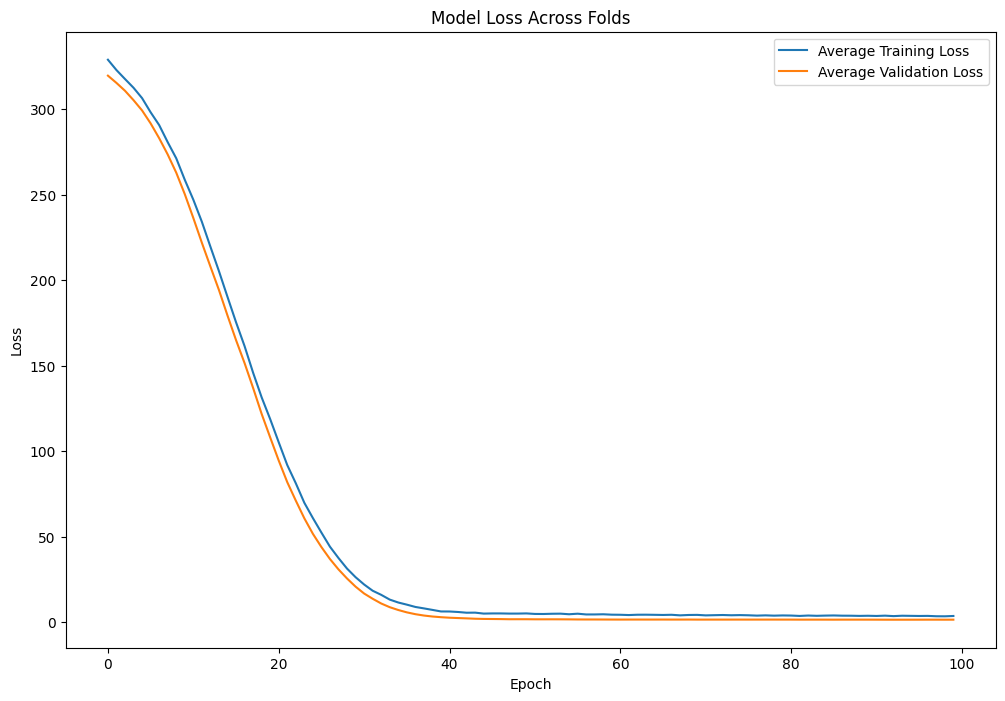

In [28]:


def create_model(input_dim):
    model = Sequential([
        Dense(100, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(20, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
losses = []
val_losses = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model = create_model(X_train.shape[1])

    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=100, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=0)

    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    print(f'Fold {fold_no} trained. validation loss: {history.history["val_loss"][-1]}')
    
    fold_no += 1

avg_loss = np.mean(losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [31]:

model = Sequential([
    Dense(4000, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(4000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.4),
    Dense(4000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.3),
    Dense(250, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, activation='relu'),
    BatchNormalization(),
    Dense(1)  # No activation for output layer
])
model.summary()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,  
    validation_data=(X_test, y_test),
    callbacks=[ early_stopping, reduce_lr] #! early_stopping,
)

test_loss = model.evaluate(X_test, y_test)
mse = mse(helper.revenue_exp(y_test), helper.revenue_exp(model.predict(X_test)))
print(f'Test loss: {test_loss}')
y_pred = model.predict(X_test)



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 4000)              112000    
                                                                 
 batch_normalization_69 (Ba  (None, 4000)              16000     
 tchNormalization)                                               
                                                                 
 dropout_66 (Dropout)        (None, 4000)              0         
                                                                 
 dense_88 (Dense)            (None, 4000)              16004000  
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 4000)              0         
                                                                 
 batch_normalization_70 (Ba  (None, 4000)              16000     
 tchNormalization)                                   

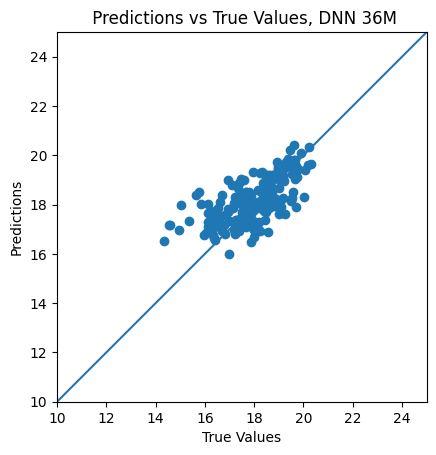

In [ ]:
plt.scatter(y_test, y_pred)
plt.title(' Predictions vs True Values, DNN 36M')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,25])
plt.ylim([10,25])
_ = plt.plot([-100, 100], [-100, 100])

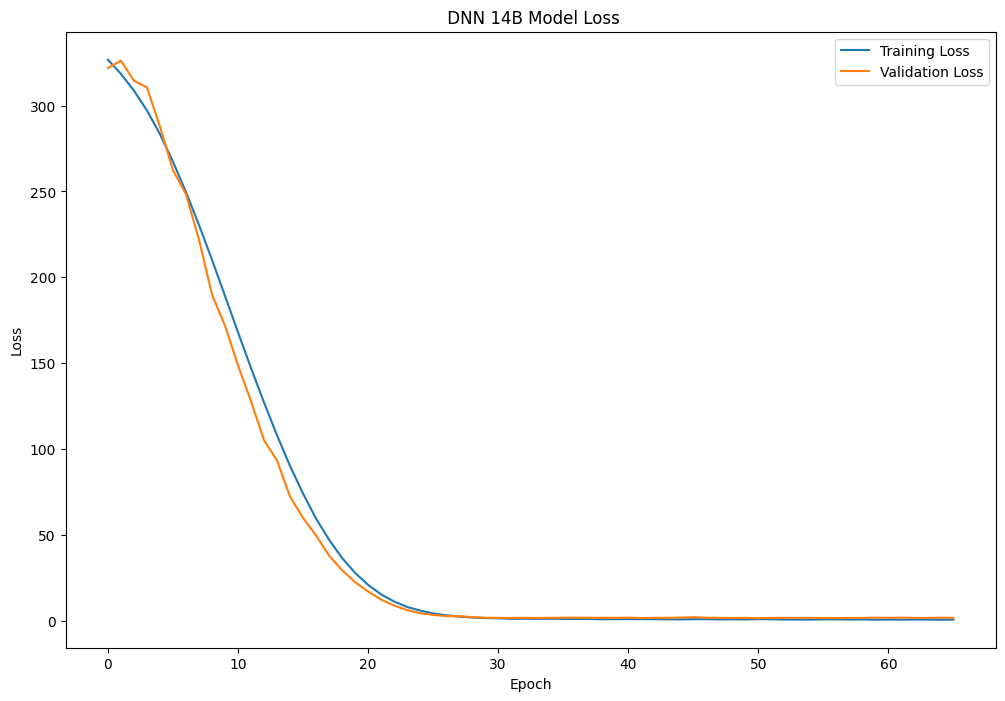

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(' DNN 36M Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
ratio = helper.revenue_exp(y_test) / helper.revenue_exp(y_pred.flatten())
print("ratio:",)
print(ratio.describe())
print("mse:", end = "")
print(mse)
rmse = sqrt(mse)
print(f"{rmse = }")

ratio:
count    206.000000
mean       1.160832
std        1.029697
min        0.000003
25%        0.480899
50%        0.850165
75%        1.450590
max        6.048036
Name: revenue, dtype: float64
mse:8393525478165039.0
rmse = 91616185.67788684


In [30]:
for i in range(10,20):
    print(f'{y_test.iloc[i]:.2f} -> {y_pred.flatten()[i]:.2f} -> {ratio.iloc[i]:.2f}')

18.17 -> 17.41 -> 1.38
20.07 -> 19.32 -> 1.94
18.51 -> 18.76 -> 0.62
18.38 -> 16.97 -> 1.52
16.70 -> 16.60 -> 0.68
16.04 -> 16.49 -> 0.45
17.27 -> 17.85 -> 0.43
17.49 -> 16.54 -> 1.02
17.88 -> 17.48 -> 1.52
17.21 -> 18.26 -> 0.33
